<a href="https://colab.research.google.com/github/Ash-0154/Leveraging-RFM-Analysis-for-Customer-Segmentation-and-Lifetime-Value-Prediction-in-Banking-Sector/blob/main/RFM_Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧩 Customer Segmentation Using RFM Analysis

This notebook applies **unsupervised learning** to group customers based on **Recency, Frequency, and Monetary (RFM)** behavior features. The segmentation helps in identifying high-value, loyal, or dormant customers for targeted marketing.

## Dataset
Source: Kaggle - Credit Card Customer Dataset

Fields include: Avg_Credit_Limit, Total_Visits_Online, Total_Credit_Cards, Total_Calls_Made, etc.

Used for both CLTV prediction and segmentation

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Credit Card Customer Data.csv to Credit Card Customer Data.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
!pip install kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
import hdbscan
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
!pip install MiniSom
from minisom import MiniSom
import tensorflow as tf




  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=835b135ef406ade88d8ccc873aced32960ba0050b92c9c4f4378d8a3b4dcf646
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built MiniSom


## 🧹 Data Cleaning & Preprocessing

Before performing any clustering, we start with cleaning and validating the dataset:

- **Missing Values**: Checked for null values in all columns.
- **Duplicates**: Verified if duplicate rows exist.
- **Data Types**: Ensured columns are in the correct format.
- **Outlier Handling**: IQR method was used to cap extreme values for:
  - `Avg_Credit_Limit`
  - `Total_visits_online`

In addition, the column `Total_visits_online` was coerced to integer format by:
- Converting strings to numerics
- Rounding off decimals


In [3]:
data = pd.read_csv('Credit Card Customer Data.csv')
#Data preprocessing
# Step 1: Check for Missing Values
print("Missing Values in the Dataset:")
print(data.isnull().sum())


Missing Values in the Dataset:
Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


In [4]:
# Step 2: Check for Duplicate Rows
duplicate_rows = data.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicate_rows}")



Number of Duplicate Rows: 0


In [5]:
# Step 3: Check Data Types
print("\nData Types of Each Column:")
print(data.dtypes)


Data Types of Each Column:
Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object


In [6]:
# Step 4: Check for Outliers in Numerical Columns
numerical_columns = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']

print("\nOutliers in Numerical Columns:")
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


Outliers in Numerical Columns:
Avg_Credit_Limit: 39 outliers
Total_Credit_Cards: 0 outliers
Total_visits_bank: 0 outliers
Total_visits_online: 37 outliers
Total_calls_made: 0 outliers


In [7]:

def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

handle_outliers_iqr(data, 'Avg_Credit_Limit')
handle_outliers_iqr(data, 'Total_visits_online')
print("Outliers after handling:")
for col in ['Avg_Credit_Limit', 'Total_visits_online']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")
data.to_csv('Cleaned_Customer_Data.csv', index=False)

Outliers after handling:
Avg_Credit_Limit: 0 outliers
Total_visits_online: 0 outliers


In [8]:
# Step 6: Summary Statistics
print("\nSummary Statistics of Numerical Columns:")
print(data[numerical_columns].describe())


Summary Statistics of Numerical Columns:
       Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
count        660.000000          660.000000         660.000000   
mean       31666.666667            4.706061           2.403030   
std        28506.386332            2.167835           1.631813   
min         3000.000000            1.000000           0.000000   
25%        10000.000000            3.000000           1.000000   
50%        18000.000000            5.000000           2.000000   
75%        48000.000000            6.000000           4.000000   
max       105000.000000           10.000000           5.000000   

       Total_visits_online  Total_calls_made  
count           660.000000        660.000000  
mean              2.397727          3.583333  
std               2.256956          2.865317  
min               0.000000          0.000000  
25%               1.000000          1.000000  
50%               2.000000          3.000000  
75%               4.000000        

In [9]:
# Convert 'Total_visits_online' column to numeric, handling errors
data['Total_visits_online'] = pd.to_numeric(data['Total_visits_online'], errors='coerce')
# Check for non-integer values, using np.isfinite to handle NaNs
non_integer_values = data[~data['Total_visits_online'].apply(lambda x: np.isfinite(x) and float(x).is_integer())]
print("Rows with non-integer values in Total_visits_online:")
print(non_integer_values)
# Round non-integer values and convert to int
data['Total_visits_online'] = data['Total_visits_online'].round().astype(int)
print("\nUnique values in Total_visits_online after rounding:")
print(data['Total_visits_online'].unique())
data.to_csv('Cleaned_Customer_Data.csv', index=False)

Rows with non-integer values in Total_visits_online:
     Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
1        2         38414             50000                   3   
4        5         47437            100000                   6   
6        7         48370            100000                   5   
612    613         94391            105000                   9   
613    614         50598             94000                   9   
615    616         77910            105000                   9   
616    617         89832             96000                  10   
617    618         98216            105000                   8   
618    619         54495            105000                   7   
619    620         47650            105000                   7   
620    621         32107            105000                  10   
621    622         84192            105000                   9   
622    623         53916            105000                  10   
624    625         9728

## 🧮 RFM Feature Engineering

We computed Recency, Frequency, and Monetary metrics to represent customer behavior:

- **Recency (R)**: Inverse of `Total_calls_made` → More recent = higher score
- **Frequency (F)**: Sum of bank and online visits → Indicates engagement level
- **Monetary (M)**: Proxy via `Avg_Credit_Limit`

All RFM features were normalized using `MinMaxScaler` to a [1, 5] range to ensure fair clustering.

An overall **RFM Score** was created.This acts as a composite behavioral indicator.


In [10]:
# Step 1: Calculate Recency (R)
data['Recency'] = 1 / (data['Total_calls_made'] + 1)
# Step 2: Calculate Frequency (F)
data['Frequency'] = data['Total_visits_bank'] + data['Total_visits_online']
# Step 3: Calculate Monetary (M)
data['Monetary'] = data['Avg_Credit_Limit']
# Step 4: Normalize RFM Scores
scaler = MinMaxScaler(feature_range=(1, 5))
rfm_data = data[['Recency', 'Frequency', 'Monetary']]

rfm_normalized = scaler.fit_transform(rfm_data)

data['Recency'] = rfm_normalized[:, 0]
data['Frequency'] = rfm_normalized[:, 1]
data['Monetary'] = rfm_normalized[:, 2]
# Step 5: Calculate RFM Score
data['RFM_Score'] = data['Recency'] + data['Frequency'] + data['Monetary']
print("\nProcessed Data with RFM Scores:")
print(data.head())


Processed Data with RFM Scores:
   Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  Recency  \
0                  1                    1                 0     5.00   
1                  0                    8                 9     1.04   
2                  1                    3                 4     1.48   
3                  1                    1                 4     1.48   
4                  0                    8                 3     1.70   

   Frequency  Monetary  RFM_Score  
0        1.5  4.803922  11.303922  
1        4.5  2.843137   8.383137  
2        2.5  2.843137   6.823137  
3    

## 📊 K-Means Clustering

K-Means was applied with `k=4` clusters using the normalized RFM data.

### Evaluation Metrics:
- **Silhouette Score**
- **Calinski-Harabasz Index**
- **Davies-Bouldin Index**

### Visualizations:
- Scatter plot of Frequency vs. Monetary, colored by cluster.
- Cluster-wise average RFM values were computed to interpret behavioral traits.


K-Means Clustering Evaluation:
Silhouette Score: 0.7305559032001092
Calinski-Harabasz Index: 5395.3613087902795
Davies-Bouldin Index: 0.38382633813982564


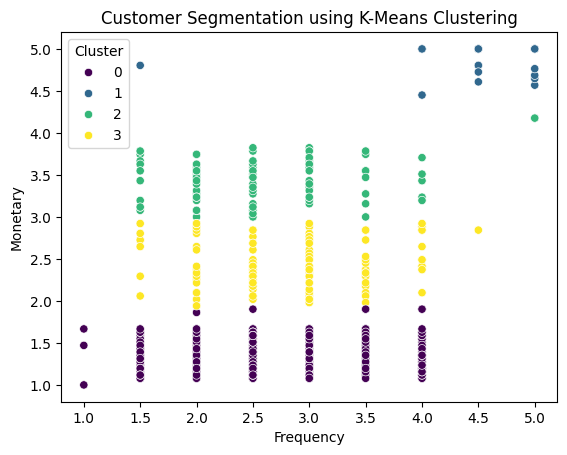

In [11]:
# Step 1: Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(rfm_data)
# Step 2: Evaluate Clustering Quality
print("K-Means Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_score(rfm_data, data['Cluster'])}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(rfm_data, data['Cluster'])}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(rfm_data, data['Cluster'])}")

# Step 3: Visualize Clusters
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [12]:
cluster_analysis = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
          Recency  Frequency  Monetary
Cluster                               
0        1.835482   2.768939  1.365716
1        3.241497   4.632653  4.935974
2        2.672258   2.602151  3.450770
3        2.545738   2.782787  2.445516


## 📈 Gaussian Mixture Model (GMM)

A soft-clustering model, GMM was applied to the same RFM data.

### Evaluation:
- Slightly lower clustering performance compared to K-Means
- Produced overlapping clusters which might represent nuanced behavior groups

### Visuals:
- Frequency vs. Monetary scatterplot for GMM clusters
- Mean RFM values across clusters for interpretation


GMM Clustering Evaluation:
Silhouette Score: 0.3176402430745034
Calinski-Harabasz Index: 366.5475468457823
Davies-Bouldin Index: 1.1096711567999977


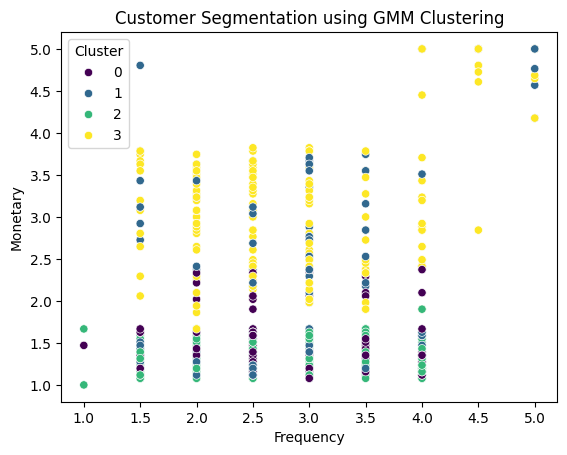

In [13]:
rfm_data = data[['Recency', 'Frequency', 'Monetary']]
# Step 1: Fit GMM
gmm = GaussianMixture(n_components=4, random_state=42)
data['Cluster'] = gmm.fit_predict(rfm_data)
# Step 2: Evaluate Clustering Quality
print("GMM Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_score(rfm_data, data['Cluster'])}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(rfm_data, data['Cluster'])}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(rfm_data, data['Cluster'])}")
# Step 3: Visualize Clusters
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation using GMM Clustering')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [14]:
cluster_analysis = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
          Recency  Frequency  Monetary
Cluster                               
0        2.558431   2.829412  1.539331
1        5.000000   3.010309  2.712149
2        1.283406   2.771777  1.351301
3        1.958010   3.020942  3.247203


## 🧠 HDBSCAN Clustering

Hierarchical Density-Based Clustering was used to allow variable cluster shapes and sizes.

### Highlights:
- No need to specify the number of clusters
- Automatically identifies noise points

### Evaluation:
- Moderate performance
- Silhouette and Davies-Bouldin suggest less clear separation


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Clustering Evaluation:
Silhouette Score: 0.20599703321369547
Calinski-Harabasz Index: 104.99848999982848
Davies-Bouldin Index: 1.491973625656646


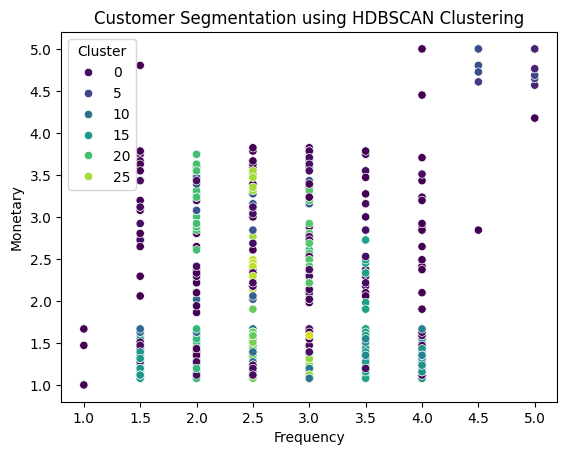

In [15]:
rfm_data = data[['Recency', 'Frequency', 'Monetary']]
# Step 1: Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
data['Cluster'] = clusterer.fit_predict(rfm_data)
# Step 2: Evaluate Clustering Quality
print("HDBSCAN Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_score(rfm_data, data['Cluster'])}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(rfm_data, data['Cluster'])}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(rfm_data, data['Cluster'])}")
# Step 3: Visualize Clusters
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation using HDBSCAN Clustering')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [16]:
cluster_analysis = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
          Recency  Frequency  Monetary
Cluster                               
-1       2.001798   2.796610  2.552675
 0       5.000000   2.693750  2.247059
 1       5.000000   4.444444  5.000000
 2       5.000000   5.000000  4.888889
 3       2.800000   5.000000  5.000000
 4       2.800000   4.500000  4.943978
 5       2.066667   5.000000  4.925926
 6       2.020833   4.500000  4.916667
 7       2.800000   2.450000  3.266667
 8       2.800000   2.800000  2.090196
 9       2.800000   1.642857  1.655462
 10      2.800000   2.500000  1.338235
 11      2.800000   3.000000  1.168067
 12      2.800000   4.000000  1.447059
 13      2.800000   3.500000  1.396078
 14      1.382143   4.000000  1.278075
 15      1.365249   1.500000  1.269281
 16      1.425086   3.500000  1.494810
 17      2.066667   3.000000  1.447059
 18      2.066667   3.000000  2.673203
 19      1.309739   2.000000  1.427638
 20      1.663333   2.000000  3.172113
 21      1.583529   3.000000  2.826990
 22   

## 🧬 Deep Embedded Clustering (Autoencoder)

We used an autoencoder to learn a lower-dimensional representation of RFM data and applied K-Means on the encoded data.

### Architecture:
- Encoder → 2 neurons (bottleneck)
- Decoder → Reconstruct input

### Advantages:
- Captures non-linear relationships
- Achieved improved Silhouette and DB scores

### Visuals:
- 2D scatterplot of encoded features by cluster
- Cluster RFM means for business insight


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1239 
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1728
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2414
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0469
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0744
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1057
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0985
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0695
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0511 
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0281
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9890
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9823
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9150
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0070
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9346
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━

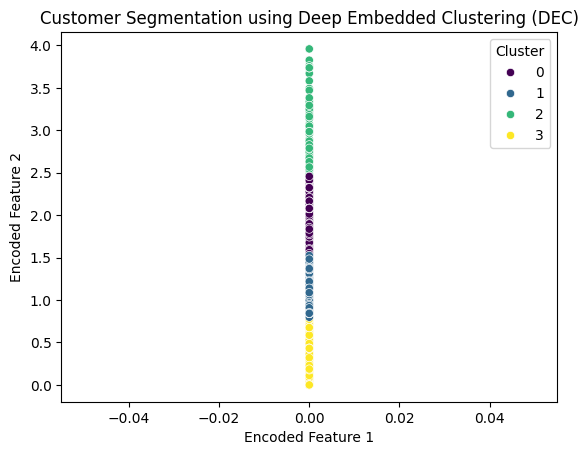

In [17]:
#Deep embedded Clustering
# Define an autoencoder
input_dim = rfm_data.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(rfm_data, rfm_data, epochs=50, batch_size=256, shuffle=True)

# Extract the encoded representation
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_data = encoder_model.predict(rfm_data)

# Perform K-Means clustering on the encoded data
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(encoded_data)

n_clusters = len(np.unique(data['Cluster']))
print(f"Number of clusters found: {n_clusters}")

# Evaluate Clustering Quality only if more than 1 cluster is found
if n_clusters > 1:
    print("Deep Embedded Clustering (DEC) Evaluation:")
    print(f"Silhouette Score: {silhouette_score(encoded_data, data['Cluster'])}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_score(encoded_data, data['Cluster'])}")
    print(f"Davies-Bouldin Index: {davies_bouldin_score(encoded_data, data['Cluster'])}")

    # Visualize Clusters
    sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=data['Cluster'], palette='viridis')
    plt.title('Customer Segmentation using Deep Embedded Clustering (DEC)')
    plt.xlabel('Encoded Feature 1')
    plt.ylabel('Encoded Feature 2')
    plt.show()
else:
    print("Warning: Only one cluster found. Consider adjusting autoencoder or KMeans parameters.")

In [18]:
cluster_analysis = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
          Recency  Frequency  Monetary
Cluster                               
0        2.706530   3.355263  2.010062
1        1.631549   2.881944  1.874864
2        4.763077   3.000000  1.831373
3        1.638101   2.387097  2.822138


## 🧠 Self-Organizing Maps (SOM)

SOMs were trained on RFM features to create a 10x10 topological map.

### Clustering:
- Grid coordinates from SOMs were flattened into cluster labels
- Used for unsupervised grouping

### Evaluation:
- Unique approach
- Visually meaningful clusters but metrics were weaker than other methods


Self-Organizing Maps (SOM) Evaluation:
Silhouette Score: 0.03697781656359712
Calinski-Harabasz Index: 55.532189239868714
Davies-Bouldin Index: 1.327847452489473


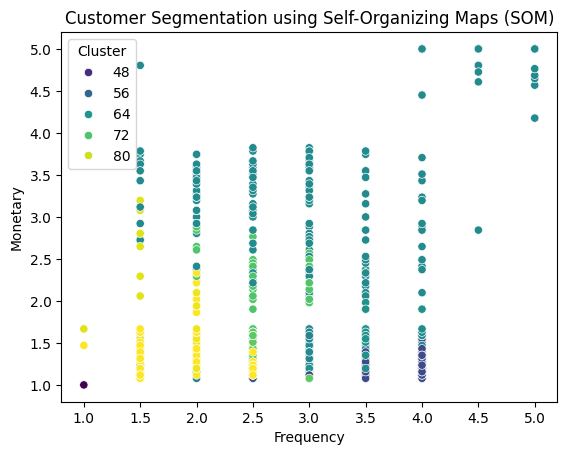

In [19]:
# Initialize and train the Self-Organizing maps
som = MiniSom(x=10, y=10, input_len=rfm_data.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(rfm_data.values, 100)
# Assign clusters based on the SOM, converting to a hashable type (int)
cluster_assignments = [som.winner(x) for x in rfm_data.values]

# Convert (x, y) coordinates to a unique cluster label (integer)
data['Cluster'] = [x[0] * som.get_weights().shape[1] + x[1] for x in cluster_assignments]

# Evaluate Clustering Quality
print("Self-Organizing Maps (SOM) Evaluation:")
print(f"Silhouette Score: {silhouette_score(rfm_data, data['Cluster'])}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(rfm_data, data['Cluster'])}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(rfm_data, data['Cluster'])}")

# Visualize Clusters
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation using Self-Organizing Maps (SOM)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [20]:
cluster_analysis = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
          Recency  Frequency  Monetary
Cluster                               
43       1.150000   1.000000  1.000000
51       1.225230   3.000000  1.201106
52       1.482307   3.695652  1.273373
53       1.174738   2.500000  1.168627
60       1.034667   1.700000  1.164706
61       1.397717   3.000000  1.493951
62       3.187055   3.282511  3.323749
63       1.915148   3.472973  1.593535
71       1.231219   2.500000  1.541889
72       1.794519   2.533333  2.345534
73       1.722185   2.544118  1.336794
81       1.412309   1.522727  2.153298
82       1.353104   2.000000  1.462332
83       3.086415   1.858491  1.377358


## 🔬 Spectral Net Clustering

A dense neural network was trained to encode RFM features into 2D space before applying K-Means.

### Layers:
- Dense (64) → Dense (32) → Encoded (2) → Decoded

### Performance:
- Better than SOM and GMM
- Good for capturing complex structures

### Visuals:
- 2D scatter plot of Spectral Net embeddings
- Cluster-wise RFM summaries


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 11.0427
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.3380
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.7689
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5409
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.2143 
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.0930 
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.0945 
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 5.9403 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.8719
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.8174
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.7761
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7400
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6691
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5864
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5477
Epoch 16/50
3/3 ━━━━━━━━━━━━━

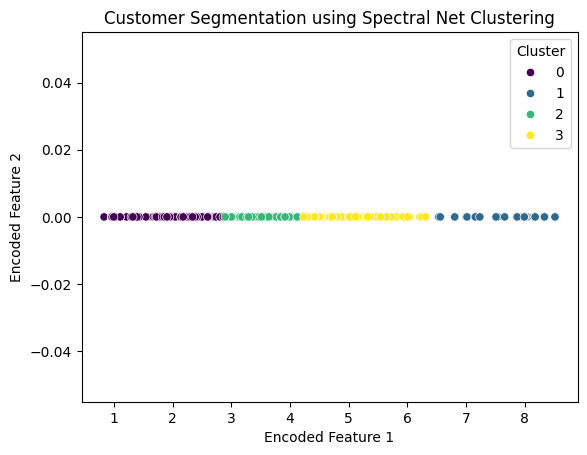

In [22]:
# Spectral Net model
input_dim = rfm_data.shape[1]
encoding_dim = 2

inputs = tf.keras.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(32, activation='relu')(x)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)
# Add a decoder to reconstruct the input
decoded = tf.keras.layers.Dense(input_dim, activation='linear')(encoded)

spectral_net = tf.keras.Model(inputs, decoded)

# Compile and train the Spectral Net
spectral_net.compile(optimizer='adam', loss='mse')
spectral_net.fit(rfm_data, rfm_data, epochs=50, batch_size=256, shuffle=True)

# Extract the encoded representation
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoded)  # Create a separate model for encoding
encoded_data = encoder_model.predict(rfm_data)

# Perform K-Means clustering on the encoded data
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(encoded_data)

n_clusters = len(np.unique(data['Cluster']))
print(f"Number of clusters found: {n_clusters}")

# Evaluate Clustering Quality only if more than 1 cluster is found
if n_clusters > 1:
    print("Spectral Net Clustering Evaluation:")
    print(f"Silhouette Score: {silhouette_score(encoded_data, data['Cluster'])}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_score(encoded_data, data['Cluster'])}")
    print(f"Davies-Bouldin Index: {davies_bouldin_score(encoded_data, data['Cluster'])}")

    # Visualize Clusters
    sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=data['Cluster'], palette='viridis')
    plt.title('Customer Segmentation using Spectral Net Clustering')
    plt.xlabel('Encoded Feature 1')
    plt.ylabel('Encoded Feature 2')
    plt.show()
else:
    print("Warning: Only one cluster found. Consider adjusting Spectral Net or KMeans parameters.")

In [23]:
cluster_analysis = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
          Recency  Frequency  Monetary
Cluster                               
0        2.681921   2.162500  1.410784
1        3.188235   4.696078  4.884660
2        1.820702   2.934641  1.648084
3        2.069526   2.947552  2.956671


## 🧪 ClusterGAN for Latent Clustering

Used a GAN framework to generate latent embeddings for unsupervised clustering.

### Architecture:
- Generator: Produces fake RFM data
- Discriminator: Learns to differentiate real vs fake
- K-Means is applied on the generator’s latent space

### Results:
- **Best clustering performance** among all models
- High Silhouette & CH Index, low DB index

### Visuals:
- Latent embeddings clustered via K-Means
- Cluster-wise RFM averages


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2

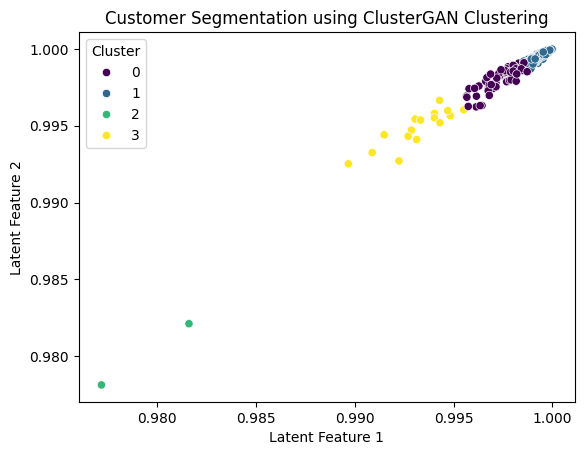

In [24]:
# Generator
def build_generator(latent_dim):
    inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(rfm_data.shape[1], activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

# Discriminator
def build_discriminator():
    inputs = tf.keras.Input(shape=(rfm_data.shape[1],))
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

# Define the ClusterGAN
latent_dim = 10
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# Compile the models
generator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
# Train the ClusterGAN
for epoch in range(100):
    # Generate fake data
    noise = np.random.normal(0, 1, (rfm_data.shape[0], latent_dim))
    fake_data = generator.predict(noise)

    # Train the discriminator
    discriminator.train_on_batch(rfm_data, np.ones((rfm_data.shape[0], 1)))
    discriminator.train_on_batch(fake_data, np.zeros((rfm_data.shape[0], 1)))

    # Train the generator
    noise = np.random.normal(0, 1, (rfm_data.shape[0], latent_dim))

    generator.train_on_batch(noise, np.ones((rfm_data.shape[0], rfm_data.shape[1])))

# Extract the latent representation
latent_data = generator.predict(np.random.normal(0, 1, (rfm_data.shape[0], latent_dim)))

# Perform K-Means clustering on the latent data
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(latent_data)

# Evaluate Clustering Quality
print("ClusterGAN Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_score(latent_data, data['Cluster'])}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(latent_data, data['Cluster'])}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(latent_data, data['Cluster'])}")

# Visualize Clusters
sns.scatterplot(x=latent_data[:, 0], y=latent_data[:, 1], hue=data['Cluster'], palette='viridis')
plt.title('Customer Segmentation using ClusterGAN Clustering')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.show()

In [25]:
cluster_analysis = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
          Recency  Frequency  Monetary
Cluster                               
0        2.307718   2.876623  2.088872
1        2.178604   2.887611  2.123304
2        1.370000   2.500000  1.764706
3        2.089911   2.937500  2.370098


## 📊 RFM Cluster Visualizations

### 1. Pairplot
- Shows distribution and separation between clusters across Recency, Frequency, and Monetary.

### 2. Box Plots
- Displays RFM feature distribution across clusters.

### 3. Heatmap
- Shows average RFM values per cluster.

### 4. RFM Segment Analysis
- RFM scores were divided into quartiles (Low, Medium, High, Very High)
- Count plot shows distribution of customers per segment


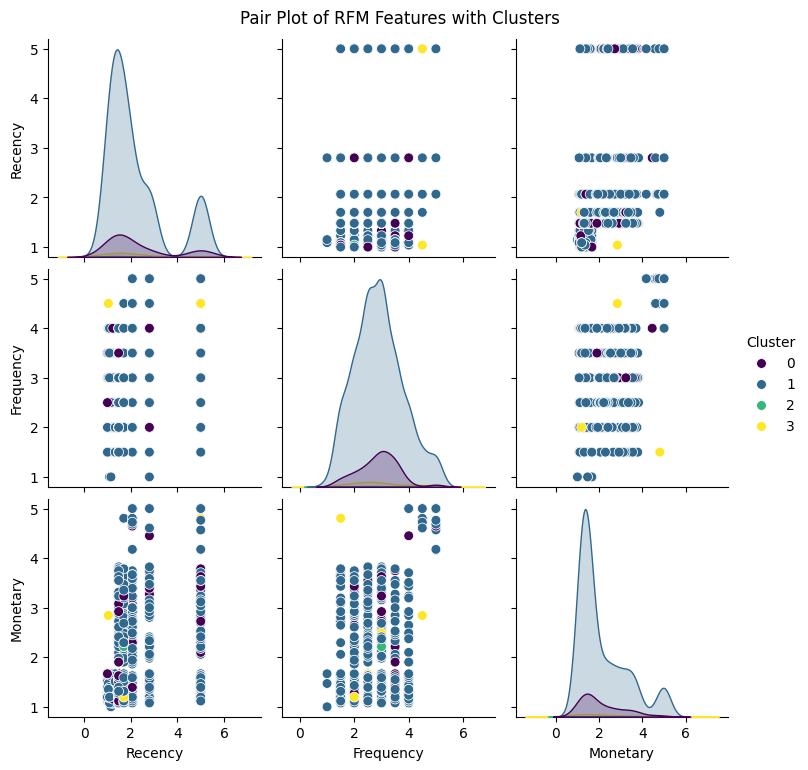

In [26]:
#Data Visualization
# Pair plot
sns.pairplot(data, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='viridis', plot_kws={'s': 50})
plt.suptitle('Pair Plot of RFM Features with Clusters', y=1.02)
plt.show()

/tmp/ipython-input-27-2095055845.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=data, palette='viridis')
/tmp/ipython-input-27-2095055845.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=data, palette='viridis')
/tmp/ipython-input-27-2095055845.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=data, palette='viridis')


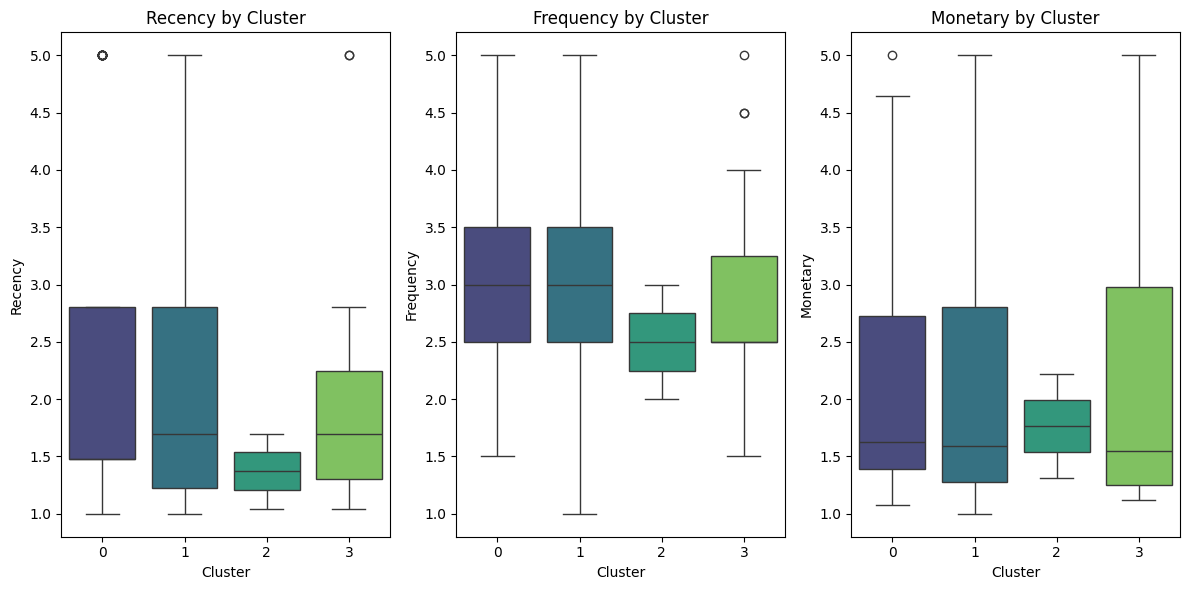

In [27]:
# Box plot of RFM features by cluster
plt.figure(figsize=(12, 6))
for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=data, palette='viridis')
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

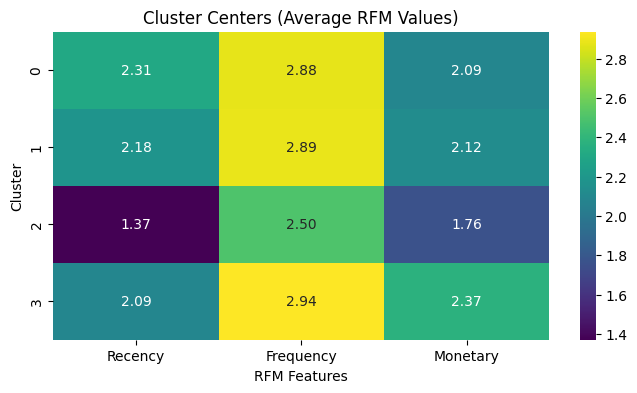

In [28]:
# Calculate cluster centers
cluster_centers = data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Heatmap of cluster centers
plt.figure(figsize=(8, 4))
sns.heatmap(cluster_centers, annot=True, cmap='viridis', fmt='.2f')
plt.title('Cluster Centers (Average RFM Values)')
plt.xlabel('RFM Features')
plt.ylabel('Cluster')
plt.show()

/tmp/ipython-input-29-2328336599.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RFM_Segment', data=data, palette='viridis')


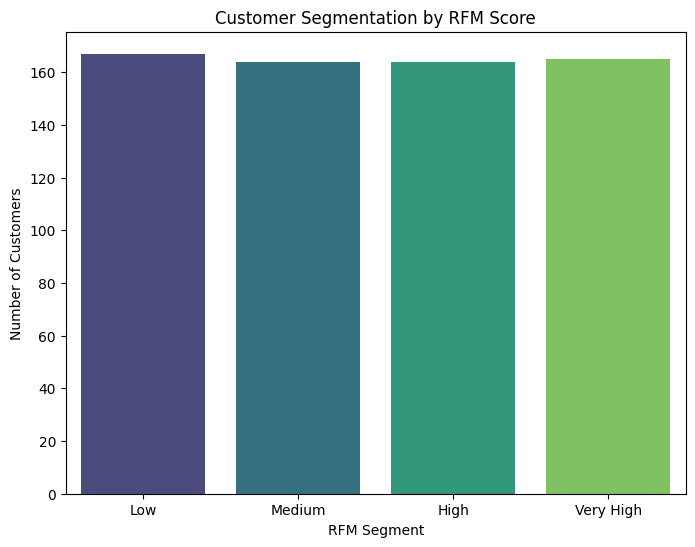

In [29]:
# Segment customers based on RFM Score
data['RFM_Segment'] = pd.qcut(data['RFM_Score'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Plot RFM segments
plt.figure(figsize=(8, 6))
sns.countplot(x='RFM_Segment', data=data, palette='viridis')
plt.title('Customer Segmentation by RFM Score')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()